This script predicts loan status using processed features and data from DataExploration0.ipynb. Parameter tuning is performed both by a grid search and by Bayes optimization.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from time import strptime

from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc
import xgboost as xgb
from bayes_opt import BayesianOptimization

In [2]:
# define some helper functions

def plotFeatureImportance(model, ntop):
    model_fnames = dict(zip(model.feature_names,full_vars))
    feature_importance = pd.DataFrame.from_dict(model.get_fscore(),orient='index')
    feature_importance.rename(index=model_fnames, inplace=True)
    feature_importance.columns = ['importance']
    feature_importance.importance = feature_importance.importance/ feature_importance.importance.sum()
    # plot 
    plt.figure()
    feature_importance.sort_values(by='importance',ascending=False).head(ntop).\
        sort_values(by='importance').plot(kind='barh',figsize=(10,int(ntop/4)+1))
    plt.title('top %d features' % ntop)
    
def plotROC(model):
    res_train = model.predict(xgb.DMatrix(train_x))
    res_val = model.predict(xgb.DMatrix(val_x))
    res_test = model.predict(xgb.DMatrix(test[full_vars].values))

    fpr_train, tpr_train, cut_train = roc_curve(y_true=train_y, y_score=res_train)
    fpr_val,   tpr_val,   cut_val   = roc_curve(y_true=val_y  , y_score=res_val)
    fpr_test,  tpr_test,  cut_test  = roc_curve(y_true=test_y , y_score=res_test)

    auc_train = auc(x=fpr_train, y=tpr_train)
    auc_val   = auc(x=fpr_val  , y=tpr_val)
    auc_test  = auc(x=fpr_test , y=tpr_test)

    print ('auc roc of train: %0.3f' % auc_train)
    print ('auc roc of validation: %0.3f' % auc_val)
    print ('auc roc of test: %0.3f' % auc_test)

    # plot
    plt.figure(figsize=(5,5))
    plt.plot(fpr_train, tpr_train, label='auc roc train: %0.3f'%auc_train, color='red')
    plt.plot(fpr_val, tpr_val, label='auc roc validation: %0.3f'%auc_val, color='blue')
    plt.plot(fpr_test, tpr_test, label='auc roc test: %0.3f'%auc_test, color='black')
    plt.plot([0,1],[0,1],'k--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")

### setup fitting data

In [3]:
# load processed data and features
df = pd.read_csv('../data/train_test2014.csv')
print 'size of processed full data: ',df.shape

import pickle
with open('../data/fnames.pickle','r') as f:
    fnames_numeric, fnames_le, fnames_obj = pickle.load(f)
print 'number of numeric and categorical features are: %d, %d' % (len(fnames_numeric),len(fnames_le))

/Users/wantingxu/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


size of processed full data:  (211907, 128)
number of numeric and categorical features are: 71, 8


In [4]:
# train-test split
full_vars = fnames_numeric + fnames_le
#full_vars = fnames_numeric
full_vars = [x for x in full_vars if x not in \
    ['lastcreditpulld_iss_diff']]
target_var = 'loanstatus'

train = df.query('fitting_flag==1')
y = df.query('fitting_flag==1')[target_var].values
test = df.query('fitting_flag==0')
test_y = df.query('fitting_flag==0')[target_var].values

print ('train data size', train.shape, 'test data size', test.shape)

('train data size', (146996, 128), 'test data size', (64911, 128))


In [5]:
# train-validation split
train_x = train.query("issued not in ['Jul-2014','Aug-2014','Sep-2014']")[full_vars].values
train_y = train.query("issued not in ['Jul-2014','Aug-2014','Sep-2014']")[target_var].values

val_x = train.query("issued in ['Jul-2014','Aug-2014','Sep-2014']")[full_vars].values
val_y = train.query("issued in ['Jul-2014','Aug-2014','Sep-2014']")[target_var].values

print ('train size', train_x.shape, 'validation size', val_x.shape, 'sum', train_x.shape[0]+val_x.shape[0])

('train size', (94093, 78), 'validation size', (52903, 78), 'sum', 146996)


In [6]:
# define xgb matrices
xgtrain = xgb.DMatrix(train_x, label=train_y)
xgval = xgb.DMatrix(val_x, label=val_y)
watchlist = [(xgtrain,'train'),(xgval,'eval')]

### default parameters

In [7]:
# a baseline fitting
params={
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed':1234,
    'eta':0.1,
    'gamma':0,
    'max_depth':6,
    'min_child_weight':1,
    'colsample_bytree':1,
    'subsample':1
}

model_base = xgb.train(params, xgtrain, num_boost_round=100000, evals=watchlist,\
    early_stopping_rounds=50, verbose_eval=50)
best_iteration = model_base.best_iteration
best_score = model_base.best_score
print ('best_score: %f, best_iteration: %d' % (best_score, best_iteration))

[0]	train-auc:0.860701	eval-auc:0.847128
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
[50]	train-auc:0.895686	eval-auc:0.869404
[100]	train-auc:0.912325	eval-auc:0.871176
Stopping. Best iteration:
[94]	train-auc:0.910818	eval-auc:0.871263

best_score: 0.871263, best_iteration: 94


auc roc of train: 0.922
auc roc of validation: 0.871
auc roc of test: 0.834


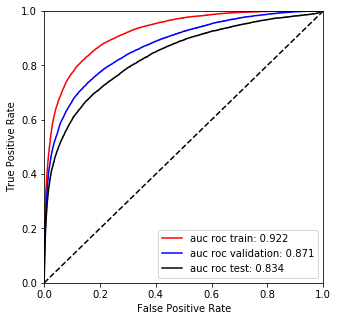

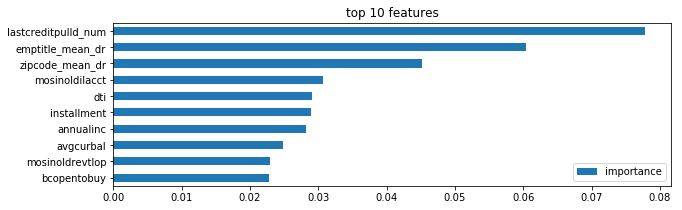

In [8]:
plotROC(model_base)
plotFeatureImportance(model_base, 10)

### manual tuning by grid search

In [9]:
# gamma: minimum loss reduction required to make a further partition on a leaf node of the tree.
# max_depth: maximum depth of a tree.
# min_child_weight: minimum sum of instance weight (hessian) needed in a child.
# subsample: subsample ratio of the training instance.
# colsample_bytree: subsample ratio of columns when constructing each tree.

In [10]:
# grid search space
xgb_par_space={}
xgb_par_space['max_depth']=[4, 5, 6, 7, 8, 9, 10]
xgb_par_space['gamma']=[0, 0.5, 1, 1.5, 2, 3]
xgb_par_space['min_child_weight']=[0, 1, 3, 5, 10, 30, 50]
xgb_par_space['colsample_bytree']=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
xgb_par_space['subsample']=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# starting values
xgb_params = {
    'max_depth': 6, 'colsample_bytree': 1, 'gamma':0, 'min_child_weight': 1,'subsample': 1, \
    'eta': 0.1, 'seed': 1234, 'silent':1, 'objective': 'binary:logistic', 'eval_metric':'auc'}

In [11]:
xgb_par_name = ['subsample','colsample_bytree','max_depth','gamma','min_child_weight']

all_scores={}
for p in xgb_par_name:
    print ("Tuning parameter %s in %s" % (p, xgb_par_space[p]))
    params = xgb_params
    scores = []
    for v in xgb_par_space[p]:
        print ('    %s: %s' % (p, v))
        params[p] = v
        model = xgb.train(params,xgtrain,num_boost_round=100000,\
            evals=watchlist, early_stopping_rounds=50, verbose_eval=False)
        best_iteration = model.best_iteration
        best_score = model.best_score
        print (', best_score: %f, best_iteration: %d' % (best_score, best_iteration))
        scores.append([v, best_score])
    best_param_value = sorted(scores, key=lambda x:x[1],reverse=True)[0][0]
    best_param_score = sorted(scores, key=lambda x:x[1],reverse=True)[0][1]
    xgb_params[p] = best_param_value
    all_scores[p]=scores
    print ("Best %s is %s with a score of %f" %(p, best_param_value, best_param_score))

Tuning parameter subsample in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    subsample: 0.1
, best_score: 0.861809, best_iteration: 77
    subsample: 0.2
, best_score: 0.867049, best_iteration: 65
    subsample: 0.3
, best_score: 0.869245, best_iteration: 67
    subsample: 0.4
, best_score: 0.870373, best_iteration: 75
    subsample: 0.5
, best_score: 0.870463, best_iteration: 98
    subsample: 0.6
, best_score: 0.871006, best_iteration: 96
    subsample: 0.7
, best_score: 0.872042, best_iteration: 109
    subsample: 0.8
, best_score: 0.871776, best_iteration: 109
    subsample: 0.9
, best_score: 0.871964, best_iteration: 94
    subsample: 1
, best_score: 0.871263, best_iteration: 94
Best subsample is 0.7 with a score of 0.872042
Tuning parameter colsample_bytree in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    colsample_bytree: 0.1
, best_score: 0.868807, best_iteration: 228
    colsample_bytree: 0.2
, best_score: 0.871114, best_iteration: 150
    colsample_bytree: 0.3
, 

* finer search for selected parameters

In [12]:
# finer search space for selected parameters
xgb_par_space={}
xgb_par_space['min_child_weight']=[15, 20, 25, 28, 30, 32, 35, 40, 45]
xgb_par_space['colsample_bytree']=[0.63, 0.65, 0.68, 0.7, 0.72, 0.75, 0.77]
xgb_par_space['subsample']=[0.63, 0.65, 0.68, 0.7, 0.72, 0.75, 0.77]

xgb_par_name = ['min_child_weight','subsample','colsample_bytree']

all_scores1={}
for p in xgb_par_name:
    print ("Tuning parameter %s in %s" % (p, xgb_par_space[p]))
    params = xgb_params
    scores = []
    for v in xgb_par_space[p]:
        print ('    %s: %s' % (p, v))
        params[p] = v
        model = xgb.train(params,xgtrain,num_boost_round=100000,\
            evals=watchlist, early_stopping_rounds=50, verbose_eval=False)
        best_iteration = model.best_iteration
        best_score = model.best_score
        print (', best_score: %f, best_iteration: %d' % (best_score, best_iteration))
        scores.append([v, best_score])
    best_param_value = sorted(scores, key=lambda x:x[1],reverse=True)[0][0]
    best_param_score = sorted(scores, key=lambda x:x[1],reverse=True)[0][1]
    xgb_params[p] = best_param_value
    all_scores1[p]=scores
    print ("Best %s is %s with a score of %f" %(p, best_param_value, best_param_score))

Tuning parameter min_child_weight in [15, 20, 25, 28, 30, 32, 35, 40, 45]
    min_child_weight: 15
, best_score: 0.872837, best_iteration: 204
    min_child_weight: 20
, best_score: 0.873242, best_iteration: 189
    min_child_weight: 25
, best_score: 0.873124, best_iteration: 200
    min_child_weight: 28
, best_score: 0.873440, best_iteration: 197
    min_child_weight: 30
, best_score: 0.873359, best_iteration: 174
    min_child_weight: 32
, best_score: 0.873068, best_iteration: 197
    min_child_weight: 35
, best_score: 0.872791, best_iteration: 206
    min_child_weight: 40
, best_score: 0.872972, best_iteration: 141
    min_child_weight: 45
, best_score: 0.873040, best_iteration: 192
Best min_child_weight is 28 with a score of 0.873440
Tuning parameter subsample in [0.63, 0.65, 0.68, 0.7, 0.72, 0.75, 0.77]
    subsample: 0.63
, best_score: 0.873567, best_iteration: 175
    subsample: 0.65
, best_score: 0.873300, best_iteration: 217
    subsample: 0.68
, best_score: 0.872843, best_ite

In [13]:
xgb_man_par = xgb_params
xgb_man_score = best_param_score

* finer tuned model result

In [14]:
model_man = xgb.train(xgb_man_par, xgtrain, num_boost_round=100000, evals=watchlist,\
    early_stopping_rounds=50, verbose_eval=50)
best_iteration = model_man.best_iteration
best_score = model_man.best_score
print ('best_score: %f, best_iteration: %d' % (best_score, best_iteration))

[0]	train-auc:0.850085	eval-auc:0.837539
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
[50]	train-auc:0.883776	eval-auc:0.869487
[100]	train-auc:0.892978	eval-auc:0.87289
[150]	train-auc:0.900033	eval-auc:0.873636
[200]	train-auc:0.905933	eval-auc:0.873786
[250]	train-auc:0.910798	eval-auc:0.873709
Stopping. Best iteration:
[215]	train-auc:0.907486	eval-auc:0.873844

best_score: 0.873844, best_iteration: 215


auc roc of train: 0.912
auc roc of validation: 0.874
auc roc of test: 0.838


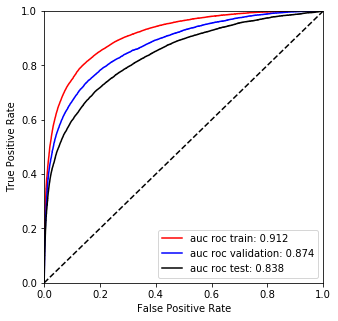

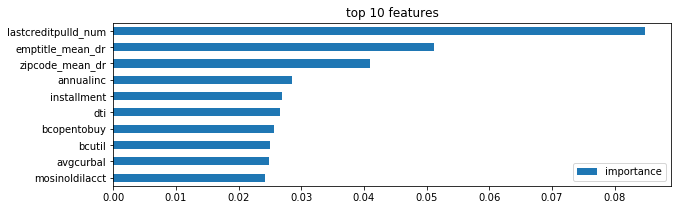

In [15]:
plotROC(model_man)
plotFeatureImportance(model_man, 10)

### automated tuning by Bayes optimization

In [16]:
# define xgb model evaluation function

def xgb_evaluate(subsample, colsample_bytree, min_child_weight, max_depth, gamma):
    params = dict()
    params['objective'] = 'binary:logistic'
    params['eta'] = 0.1
    params['max_depth'] = int(max_depth )   
    params['min_child_weight'] = int(min_child_weight)
    params['colsample_bytree'] = colsample_bytree
    params['subsample'] = subsample
    params['gamma'] = gamma
    params['seed'] = 1234  
    params['eval_metric'] = 'auc'  
    params['silent'] = 1

    model = xgb.train(params, xgtrain, num_boost_round=100000, evals=watchlist,\
        early_stopping_rounds=50, verbose_eval=False)   
    best_iteration = model.best_iteration
    best_score = model.best_score

    print (', best_score: %f, best_iteration: %d' % (best_score, best_iteration))

    return best_score

In [17]:
xgb_BO = BayesianOptimization(xgb_evaluate, 
                             {'max_depth': (4, 10),
                              'min_child_weight': (0, 40),
                              'colsample_bytree': (0.5, 1),
                              'subsample': (0.5, 1),
                              'gamma': (0, 3)
                              } )

xgb_BO.maximize(init_points=5, n_iter=40)

Initialization
---------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma |   max_depth |   min_child_weight |   subsample | 
, best_score: 0.872723, best_iteration: 236
    1 | 01m00s |    0.87272 |             0.9853 |    0.1882 |      4.5447 |             0.0455 |      0.9760 | 
, best_score: 0.872348, best_iteration: 232
    2 | 00m36s |    0.87235 |             0.5223 |    2.8630 |      4.7195 |            29.0403 |      0.6578 | 
, best_score: 0.872588, best_iteration: 109
    3 | 00m55s |    0.87259 |             0.7427 |    0.2726 |      9.4653 |            37.4531 |      0.9098 | 
, best_score: 0.871671, best_iteration: 93
    4 | 00m51s |    0.87167 |             0.7261 |    0.4662 |      9.2642 |            13.3976 |      0.9870 | 
, best_score: 0.872840, best_iteration: 102
    5 | 00m51s |    0.87284 |             0.7192 |    2.0878 |      9.5597 |            2

/Users/wantingxu/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


, best_score: 0.872268, best_iteration: 167
    8 | 00m58s |    0.87227 |             0.9815 |    0.1746 |      4.4313 |            19.5744 |      0.5077 | 
, best_score: 0.872838, best_iteration: 219
    9 | 01m12s |    0.87284 |             0.9852 |    2.8981 |      4.3988 |            13.4339 |      0.9622 | 
, best_score: 0.871642, best_iteration: 75
   10 | 01m06s |    0.87164 |             0.9462 |    2.8544 |      9.9871 |            39.7065 |      0.7127 | 


/Users/wantingxu/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00021705]), 'nit': 7, 'funcalls': 62}
  " state: %s" % convergence_dict)


, best_score: 0.873465, best_iteration: 260
   11 | 01m22s |    0.87347 |             0.9963 |    0.2554 |      4.0862 |            27.0659 |      0.9928 | 


/Users/wantingxu/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00037995]), 'nit': 5, 'funcalls': 55}
  " state: %s" % convergence_dict)


, best_score: 0.873580, best_iteration: 218
   12 | 01m25s |    0.87358 |             0.9868 |    2.9284 |      5.8305 |            30.1187 |      0.9852 | 
, best_score: 0.872419, best_iteration: 96
   13 | 01m13s |    0.87242 |             0.9952 |    0.3999 |      8.2662 |            28.8400 |      0.9844 | 


/Users/wantingxu/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -2.60564120e-05]), 'nit': 5, 'funcalls': 58}
  " state: %s" % convergence_dict)


, best_score: 0.872868, best_iteration: 259
   14 | 00m54s |    0.87287 |             0.5084 |    0.0790 |      4.0362 |             8.6393 |      0.9453 | 
, best_score: 0.872805, best_iteration: 271
   15 | 00m59s |    0.87281 |             0.5080 |    2.2463 |      4.4354 |            20.9178 |      0.9999 | 
, best_score: 0.873302, best_iteration: 386
   16 | 01m48s |    0.87330 |             0.9768 |    0.0479 |      4.1834 |            39.4881 |      0.9514 | 
, best_score: 0.873301, best_iteration: 302
   17 | 01m05s |    0.87330 |             0.5456 |    0.2441 |      4.1644 |            34.8714 |      0.9953 | 
, best_score: 0.872453, best_iteration: 103
   18 | 01m23s |    0.87245 |             0.9417 |    2.9323 |      9.7922 |            22.8826 |      0.9970 | 
, best_score: 0.869481, best_iteration: 56
   19 | 01m06s |    0.86948 |             0.9800 |    0.0532 |      9.7994 |             1.5172 |      0.9171 | 


/Users/wantingxu/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.0002935]), 'nit': 4, 'funcalls': 50}
  " state: %s" % convergence_dict)
/Users/wantingxu/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -3.08714443e-05]), 'nit': 7, 'funcalls': 58}
  " state: %s" % convergence_dict)


, best_score: 0.873046, best_iteration: 93
   20 | 01m08s |    0.87305 |             0.7537 |    2.8560 |      9.9530 |            33.9419 |      0.9889 | 
, best_score: 0.872794, best_iteration: 330
   21 | 01m36s |    0.87279 |             0.9558 |    2.8652 |      4.0599 |             2.2782 |      0.9851 | 


/Users/wantingxu/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -8.68150382e-05]), 'nit': 5, 'funcalls': 51}
  " state: %s" % convergence_dict)


, best_score: 0.873306, best_iteration: 291
   22 | 01m27s |    0.87331 |             0.9716 |    2.8239 |      4.0009 |            32.0278 |      0.9646 | 


/Users/wantingxu/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -4.47295315e-05]), 'nit': 6, 'funcalls': 54}
  " state: %s" % convergence_dict)


, best_score: 0.872602, best_iteration: 97
   23 | 00m53s |    0.87260 |             0.5393 |    1.5544 |      8.0153 |            39.9162 |      0.9942 | 


/Users/wantingxu/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -3.17334197e-05]), 'nit': 5, 'funcalls': 53}
  " state: %s" % convergence_dict)


, best_score: 0.873114, best_iteration: 248
   24 | 01m16s |    0.87311 |             0.9031 |    0.2320 |      4.1745 |            14.7378 |      0.9950 | 
, best_score: 0.872879, best_iteration: 210
   25 | 01m13s |    0.87288 |             0.9944 |    0.1408 |      4.0531 |             6.7636 |      0.9856 | 


/Users/wantingxu/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00018813]), 'nit': 5, 'funcalls': 54}
  " state: %s" % convergence_dict)
/Users/wantingxu/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00018936]), 'nit': 5, 'funcalls': 54}
  " state: %s" % convergence_dict)


, best_score: 0.873139, best_iteration: 203
   26 | 01m34s |    0.87314 |             0.9867 |    1.1090 |      6.2915 |            36.3632 |      0.9731 | 


/Users/wantingxu/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00010505]), 'nit': 7, 'funcalls': 53}
  " state: %s" % convergence_dict)


, best_score: 0.872054, best_iteration: 217
   27 | 00m54s |    0.87205 |             0.6198 |    0.3671 |      4.0698 |             0.1851 |      0.5069 | 


/Users/wantingxu/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00046668]), 'nit': 7, 'funcalls': 57}
  " state: %s" % convergence_dict)
/Users/wantingxu/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00049095]), 'nit': 5, 'funcalls': 49}
  " state: %s" % convergence_dict)


, best_score: 0.872292, best_iteration: 88
   28 | 01m21s |    0.87229 |             0.9877 |    2.9117 |      9.4115 |            28.6481 |      0.9950 | 


/Users/wantingxu/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00057621]), 'nit': 5, 'funcalls': 49}
  " state: %s" % convergence_dict)


, best_score: 0.872550, best_iteration: 145
   29 | 00m53s |    0.87255 |             0.5030 |    1.9353 |      6.9397 |             5.6454 |      0.9992 | 
, best_score: 0.871529, best_iteration: 106
   30 | 00m59s |    0.87153 |             0.5046 |    2.7784 |      9.7522 |            16.7240 |      0.9903 | 
, best_score: 0.871899, best_iteration: 109
   31 | 01m00s |    0.87190 |             0.5164 |    0.0812 |      9.3437 |            21.1192 |      0.9798 | 
, best_score: 0.872363, best_iteration: 358
   32 | 01m13s |    0.87236 |             0.5883 |    2.0843 |      4.0106 |            39.9529 |      0.5206 | 
, best_score: 0.870271, best_iteration: 96
   33 | 00m52s |    0.87027 |             0.5090 |    0.4969 |      9.9120 |            33.4870 |      0.5207 | 


/Users/wantingxu/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00239612]), 'nit': 6, 'funcalls': 55}
  " state: %s" % convergence_dict)


, best_score: 0.870830, best_iteration: 79
   34 | 00m52s |    0.87083 |             0.9277 |    1.0358 |      6.0082 |            10.4132 |      0.5038 | 


/Users/wantingxu/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -8.21387221e-05]), 'nit': 7, 'funcalls': 51}
  " state: %s" % convergence_dict)


, best_score: 0.872189, best_iteration: 76
   35 | 00m58s |    0.87219 |             0.6042 |    2.7729 |      9.9020 |             8.6126 |      0.9469 | 
, best_score: 0.872297, best_iteration: 294
   36 | 01m04s |    0.87230 |             0.5226 |    2.9002 |      4.1636 |             0.0418 |      0.9906 | 


/Users/wantingxu/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00010806]), 'nit': 7, 'funcalls': 56}
  " state: %s" % convergence_dict)


, best_score: 0.873447, best_iteration: 121
   37 | 00m50s |    0.87345 |             0.5060 |    1.3994 |      6.3104 |            25.7346 |      0.9953 | 


/Users/wantingxu/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00128989]), 'nit': 5, 'funcalls': 56}
  " state: %s" % convergence_dict)


, best_score: 0.872099, best_iteration: 356
   38 | 01m13s |    0.87210 |             0.5152 |    0.6905 |      4.2036 |             2.1397 |      0.9677 | 


/Users/wantingxu/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00011307]), 'nit': 7, 'funcalls': 64}
  " state: %s" % convergence_dict)


, best_score: 0.873222, best_iteration: 243
   39 | 01m20s |    0.87322 |             0.9691 |    2.9891 |      4.0380 |             7.3846 |      0.9753 | 
, best_score: 0.872981, best_iteration: 244
   40 | 01m12s |    0.87298 |             0.5085 |    1.7267 |      6.3200 |            31.6376 |      0.9870 | 
, best_score: 0.872535, best_iteration: 98
   41 | 00m58s |    0.87253 |             0.5347 |    2.3486 |      9.9334 |            37.3626 |      0.9362 | 
, best_score: 0.872449, best_iteration: 75
   42 | 01m15s |    0.87245 |             0.9832 |    0.3112 |      9.9701 |            39.7012 |      0.9531 | 


/Users/wantingxu/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00147112]), 'nit': 5, 'funcalls': 55}
  " state: %s" % convergence_dict)


, best_score: 0.872371, best_iteration: 103
   43 | 01m00s |    0.87237 |             0.5147 |    1.6242 |      9.9774 |            25.5424 |      0.9892 | 
, best_score: 0.873665, best_iteration: 308
   44 | 01m34s |    0.87367 |             0.9632 |    1.5684 |      4.0925 |            23.7582 |      0.9438 | 
, best_score: 0.872796, best_iteration: 171
   45 | 01m26s |    0.87280 |             0.9804 |    1.3871 |      6.5200 |            20.4272 |      0.9775 | 


In [25]:
# organize results
xgb_BO_scores = pd.DataFrame(xgb_BO.res['all']['params'])
xgb_BO_scores['score'] = pd.DataFrame(xgb_BO.res['all']['values'])
xgb_BO_scores = xgb_BO_scores.sort_values(by='score',ascending=False)
xgb_BO_scores.head()

,colsample_bytree,gamma,max_depth,min_child_weight,subsample,score
38,0.963205,1.568429,4.092482,23.758233,0.943751,0.873665
6,0.986827,2.928370,5.830526,30.118735,0.985188,0.873580
5,0.996259,0.255381,4.086208,27.065873,0.992757,0.873465
31,0.505998,1.399351,6.310354,25.734579,0.995344,0.873447
16,0.971618,2.823859,4.000919,32.027811,0.964636,0.873306


In [32]:
xgb_bo_par = xgb_BO_scores.iloc[0].to_dict()
xgb_bo_par['objective'] = 'binary:logistic'
xgb_bo_par['seed'] = 1234
xgb_bo_par['eval_metric'] = 'auc'
xgb_bo_par['eta'] = 0.1
xgb_bo_par['silent'] = 1
xgb_bo_par['max_depth'] = int(xgb_bo_par['max_depth'])
xgb_bo_par['min_child_weight'] = int(xgb_bo_par['min_child_weight'])
del xgb_bo_par['score']

In [39]:
model_bo = xgb.train(xgb_bo_par, xgtrain, num_boost_round=100000, evals=watchlist,\
    early_stopping_rounds=50, verbose_eval=50)
best_iteration = model_bo.best_iteration
best_score = model_bo.best_score
print ('best_score: %f, best_iteration: %d' % (best_score, best_iteration))

[0]	train-auc:0.849373	eval-auc:0.842188
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
[50]	train-auc:0.875133	eval-auc:0.865472
[100]	train-auc:0.886623	eval-auc:0.871241
[150]	train-auc:0.89183	eval-auc:0.872223
[200]	train-auc:0.896279	eval-auc:0.872921
[250]	train-auc:0.900059	eval-auc:0.873403
[300]	train-auc:0.903631	eval-auc:0.87361
[350]	train-auc:0.907154	eval-auc:0.873567
Stopping. Best iteration:
[308]	train-auc:0.90436	eval-auc:0.873665

best_score: 0.873665, best_iteration: 308


auc roc of train: 0.908
auc roc of validation: 0.873
auc roc of test: 0.838


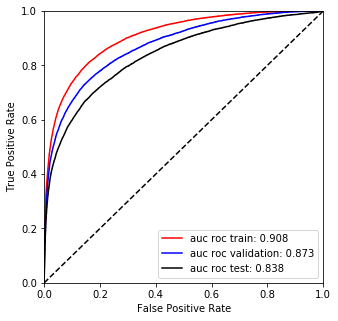

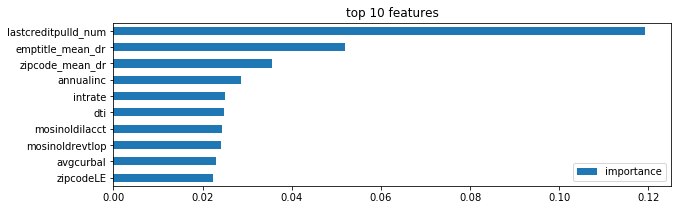

In [40]:
plotROC(model_bo)
plotFeatureImportance(model_bo, 10)

### save results

In [52]:
xgb_BO_scores.to_pickle('../data/xgb_BO_scores.pkl')

with open('../data/xgb_pars.pkl','wb') as f:
    pickle.dump([xgb_man_par, xgb_bo_par], f)